# Approach 3 - Local Features

In [1]:
%load_ext autoreload
%autoreload 2

from tqdm.notebook import tqdm
import os
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv

from py.Dataset import Dataset
from py.DatasetStatistics import DatasetStatistics
from py.Session import Session, MotionImage, LapseImage
from py.FileUtils import list_folders, list_jpegs_recursive
from py.ImageUtils import display_images

DIR = '/home/AMMOD_data/camera_traps/BayerWald/Vielkadaver-Projekt/' # dataset directory
SCALE = 0.2 # scaling factor for all images

ds = Dataset(DIR)
session = ds.create_session("beaver_01")

Found 32 sessions
Session 'Beaver_01' at folder: /home/AMMOD_data/camera_traps/BayerWald/Vielkadaver-Projekt/VIELAAS_Spring_Session01-VIELAAS_Beaver_01
Loaded scans.


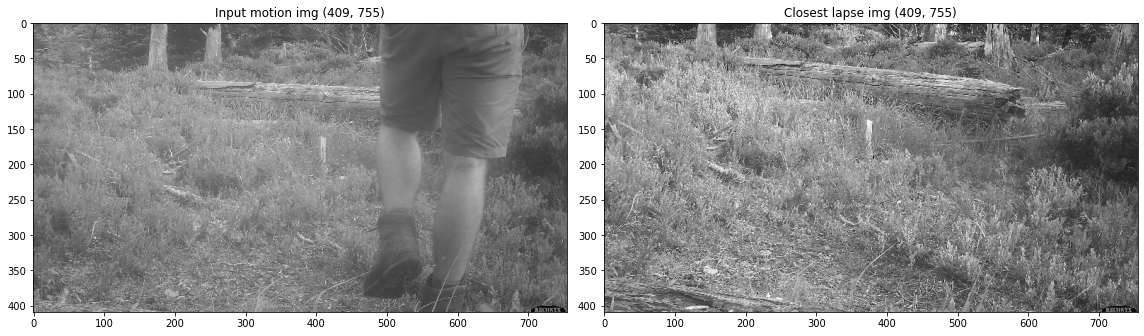

In [2]:
# Get motion image and closest lapse image for comparison
motion_img = session.get_random_motion_image(day_only=True)
before_img, after_img, rel = motion_img.get_closest_lapse_images()
closest_img = before_img if rel <= 0.5 else after_img

# read and display images
img = motion_img.read_opencv(scale=SCALE, gray=True)
comp_img = closest_img.read_opencv(scale=SCALE, gray=True)
display_images([img, comp_img], [f"Input motion img {img.shape}", f"Closest lapse img {comp_img.shape}"], cmap="gray")

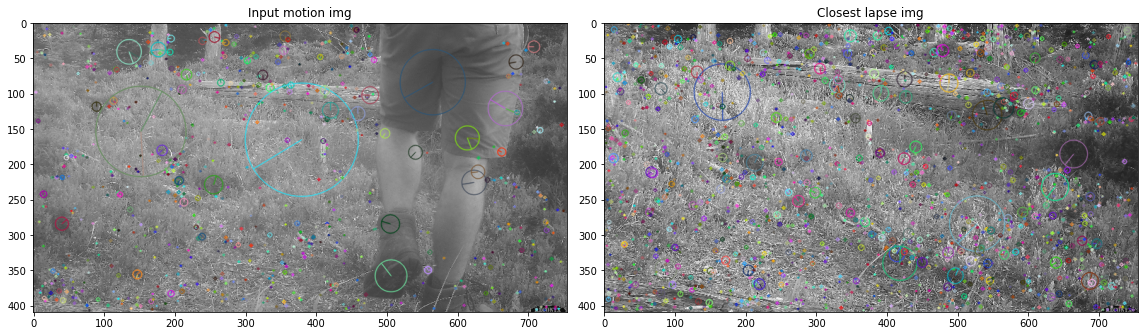

In [3]:
sift = cv.SIFT_create()
img_kp, img_des = sift.detectAndCompute(img, None)
comp_img_kp, comp_img_des = sift.detectAndCompute(comp_img, None)
kp_img = cv.drawKeypoints(img, img_kp, img, flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
comp_kp_img = cv.drawKeypoints(comp_img, comp_img_kp, comp_img, flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

display_images([kp_img, comp_kp_img], [f"Input motion img", f"Closest lapse img"])

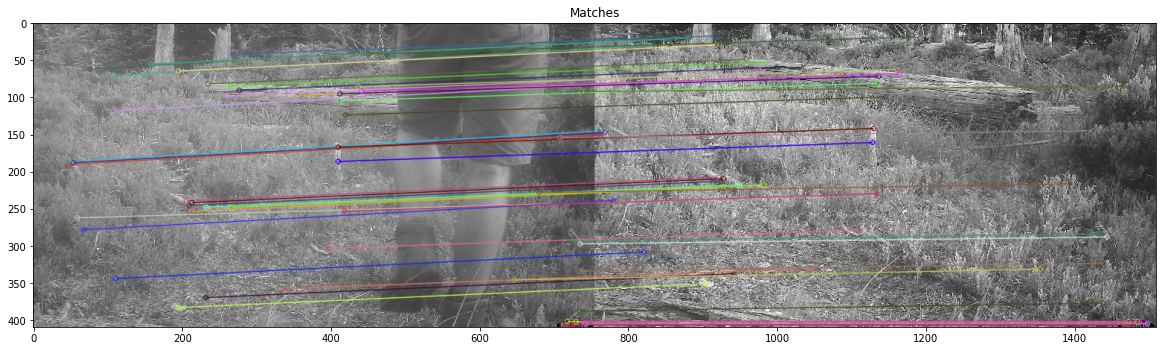

In [4]:
bf = cv.BFMatcher()
# Match descriptors, calculate best two matches
matches = bf.knnMatch(img_des, comp_img_des, k=2)

# Apply ratio test
good = []
for m,n in matches:
    if m.distance < 0.75*n.distance:
        good.append([m])

# cv.drawMatchesKnn expects list of lists as matches.
matches_img = cv.drawMatchesKnn(img, img_kp, comp_img, comp_img_kp, good, None, flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
display_images([matches_img], ["Matches"], size=(16,5))

In [5]:
# extract and save SIFT descriptors for all lapse images
sift = cv.SIFT_create()
dscs = []
for lapse_img in tqdm(session.generate_lapse_images()):
    img = lapse_img.read_opencv(scale=SCALE, gray=True)
    kp, dsc = sift.detectAndCompute(img, None)
    dscs.append(dsc)
dscs = np.array(dscs)
np.save("Cache_NoBackup/approach3_lapse_sift_descriptors.npy", dscs)

0it [00:00, ?it/s]

/home/kleinsteuber/.local/lib/python3.6/site-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  


In [3]:
dscs = np.load("Cache_NoBackup/approach3_lapse_sift_descriptors.npy", allow_pickle=True)

In [4]:
dictionary_size = 10 # number of clusters = size of dictionary
BOW = cv.BOWKMeansTrainer(dictionary_size)
for dsc in dscs:
    BOW.add(dsc)
dictionary = BOW.cluster()
np.save("Cache_NoBackup/approach3_cluster10.npy", dictionary)

In [2]:
dictionary = np.load("Cache_NoBackup/approach3_cluster10.npy")

In [3]:
FLANN_INDEX_KDTREE = 0
index_params = {"algorithm": FLANN_INDEX_KDTREE, "trees": 5}
search_params = {"checks": 50}   # or pass empty dictionary
flann = cv.FlannBasedMatcher(index_params,search_params)
sift2 = cv.xfeatures2d.SIFT_create()
bowDiction = cv.BOWImgDescriptorExtractor(sift2, flann) # or cv.BFMatcher(cv.NORM_L2)
bowDiction.setVocabulary(dictionary)

In [4]:
dscs = np.load("Cache_NoBackup/approach3_lapse_sift_descriptors.npy", allow_pickle=True)

In [ ]:
from sklearn import svm

clf = svm.OneClassSVM()